In [1]:
include("sensor.jl") # To retrieve Sensor Positions
include("./doa/cbf.jl") # Conventional Beamformer
include("./doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("./doa/music.jl") # MUSIC

include("./utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [30]:
using WAV
new_sig, sample_rate = wavread("./signal_generator/270deg_1kHz_tone_sr32kHz.wav");
# new_sig, sample_rate = wavread("./signal_generator/1000hz_circle.wav");

([-0.008880886257515184 -0.0042115543076876125 … 0.003997924741355632 -0.010345774712363049; -0.009125034333323161 -0.004608294930875576 … 0.004333628345591601 -0.010589922788171027; … ; -0.018433179723502304 -0.00924710837122715 … -0.012634662923062838 -0.03332621234778894; -0.017426068910794398 -0.00784325693533128 … -0.01568651387066256 -0.03466902676473281], 32000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x08, 0x00, 0x00, 0x7d, 0x00, 0x00, 0x00, 0xd0, 0x07, 0x00, 0x10, 0x00, 0x10, 0x00])])

In [38]:
freq = 1000;            # Frequency of Interest (in Hz)
c0 = 343;             # Speed of Medium (in m/s)
NFFT = 2^8; #2^11;
noverlap = Int(NFFT * (3 // 4));

In [39]:
include("./doa/cbf.jl")
include("./doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate, NFFT, noverlap);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);

In [49]:
using Statistics
#=
Prepate for TDoA
=#
corr_samples = 64;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_cbfs = [];
P_dbfs = [];
doas_cbfs = [];
doas_dbfs = [];

order = 1;

@time for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    Rx = cov(new_S[:, start:end_t], dims=2);

    P_cbf, az_list = cbf(Rx, sensors, freq, c0);
    P_dbf, az_list = dbf_coFree(Rx, sensors, order, freq, c0)
    __, az_cbf = predict_az(P_cbf, az_list);
    __, az_dbf = predict_az(P_dbf, az_list);

    push!(doas_cbfs, az_cbf)
    push!(doas_dbfs, az_dbf)
    push!(P_cbfs, P_cbf)
    push!(P_dbfs, P_dbf)
    if t == 1
        append!(az, az_list)
    end
end

P_cbfs = mapreduce(permutedims, vcat, P_cbfs);
P_cbfs = P_cbfs';

P_dbfs = mapreduce(permutedims, vcat, P_dbfs);
P_dbfs = P_dbfs';

weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weighting vector: Rational[1//3, 1//3, 1//3] has sum 1//1
ψ has rank 3
weight

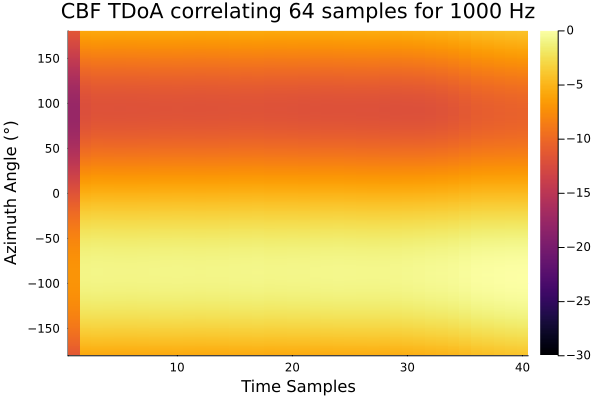

(361, 40)
  0.001087 seconds (1.36 k allocations: 229.977 KiB)


In [50]:
using Plots
using DSP.Util: pow2db
P_cbfs_db = pow2db.(P_cbfs);
P_cbfs_db .-= maximum(P_cbfs_db);
println(size(P_cbfs_db))
@time p = plot(t_doa, az, P_cbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="CBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

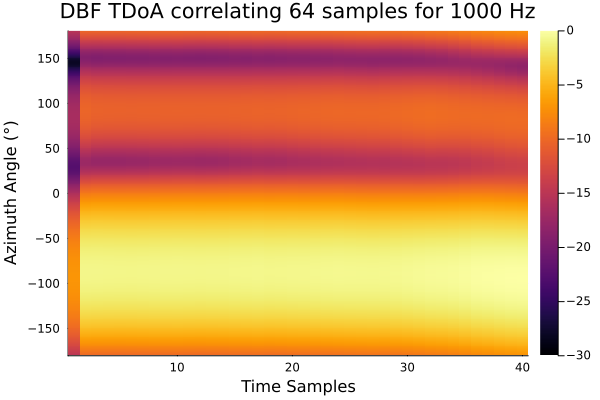

(361, 40)
  0.001033 seconds (1.36 k allocations: 229.977 KiB)


In [51]:
P_dbfs_db = pow2db.(P_dbfs);
P_dbfs_db .-= maximum(P_dbfs_db);
println(size(P_dbfs_db))
@time p = plot(t_doa, az, P_dbfs_db, st=:heatmap,
     clims=(-30.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)

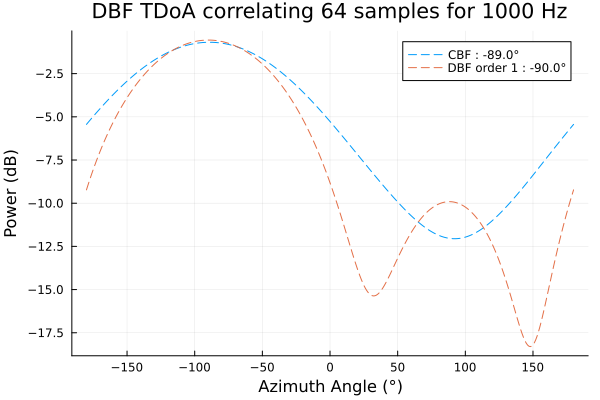

In [68]:
sam = 30;
p3 = plot(az, P_cbfs_db[:,sam], label="CBF : $(doas_cbfs[sam])°",
    linestyle=:dash);
plot!(az, P_dbfs_db[:,sam], label="DBF order $order : $(doas_dbfs[sam])°",
    linestyle=:dash);
xlabel!("Azimuth Angle (°)");
ylabel!("Power (dB)");
title!("DBF TDoA correlating $(corr_samples) samples for $(freq) Hz")
display(p3)

In [64]:
P_cbfs_db[:,sam]

361-element Vector{Float64}:
 -5.4386573443524355
 -5.345201918061363
 -5.252280337291467
 -5.159911803543835
 -5.068115149987541
 -4.976908847893455
 -4.88631101286461
 -4.796339410871283
 -4.707011464098706
 -4.6183442566150745
  ⋮
 -6.203087989267658
 -6.106099551962174
 -6.009477242047026
 -5.913243466650876
 -5.817420204687153
 -5.722029015252097
 -5.627091045739768
 -5.532627039685998
 -5.4386573443524355

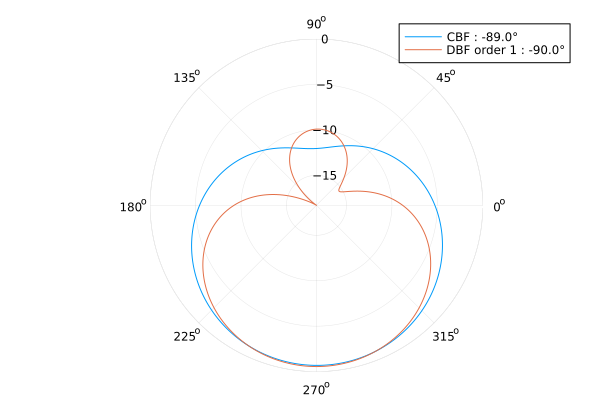

In [82]:
rmin = minimum([P_cbfs_db[:,sam] P_dbfs_db[:,sam] ]);
p4 = plot(deg2rad.(az), P_cbfs_db[:,sam],
            proj=:polar, label="CBF : $(doas_cbfs[sam])°",
    linestyle=:solid);
plot!(deg2rad.(az), P_dbfs_db[:,sam],
        proj=:polar, label="DBF order $order : $(doas_dbfs[sam])°",
    linestyle=:solid);
ylims!((rmin, 0))
# plot!(deg2rad.([90; 90]), [-30; 0], proj=:polar)
display(p4)